In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from matplotlib import pyplot as plt
import time
from decimal import Decimal, ROUND_UP
import src.PLS.metaSIR

In [2]:
def basic_square_map(N_nodes):
    dimensions =  int(np.ceil(np.sqrt(N_nodes)))
    mat = np.arange(1,N_nodes+1,1)
    for i in range(dimensions**2 - N_nodes):
        mat = np.append(mat,-1)
    mat = np.reshape(mat,(-1,dimensions))
    return mat

In [3]:
def straight_line_distances(node_map,N_nodes,scaling =1):
    distances = np.zeros((N_nodes,N_nodes))
    for i in range(1, N_nodes+1):
        node_index = np.argwhere(node_map == i)[0]
        for j in range(1, N_nodes+1):
            if i !=j:
                other_index = np.argwhere(node_map == j)[0]
                x_dist = node_index[0] - other_index[0]
                y_dist = node_index[1] - other_index[1]
                str_line = np.sqrt((x_dist)**2 + (y_dist)**2) #pythagorus
                distances[i-1,j-1] = str_line * scaling
                distances[j-1,i-1] = str_line * scaling
    return distances

In [4]:
def basic_kernel(rate,distance):
    if distance != 0:
        return rate/(distance**2)
    else:
        raise ValueError("Dividing by Zero! The Kernel is working on the same node. Stop it!")

In [5]:
def meta_SIR(X0,beta,gamma,N_nodes,distances,kernel,tmax,tstep,rng,cull_strength =0):
    """
    :param X0: The initial State of the metapopulations. Needs to match the number of nodes.
    :param beta: The rate of infection
    :param gamma: The rate of recovery
    :param nodes: The number of nodes in the system
    :param kernel: The perturbation kernel
    :param tmax:
    :param tstep:
    :param rng:
    :param cull_strength:
    :return:
    """
    #set initial conditions
    t =0.0
    times = np.array(t)
    X = np.array(X0)
    timed_sol = np.array([X0])
    sol = np.array([X0])
    times = np.array(t)
    state = np.array([X0])
    nodes = {}
    node_list = np.arange(1,N_nodes+1,1)
    #set initial infection forces
    for j in node_list:
        nodes[f"node{j}"] = {}
        nodes[f"node{j}"]["domestic_inf"] = beta*X[j-1][0]*X[j-1][1]
        nodes[f"node{j}"]["recovery"] = gamma*X[j-1][1]
        nodes[f"node{j}"]["foreign_inf"] = 0
    for j in node_list:
        other_nodes = np.delete(node_list,[j-1])
        for i in other_nodes:
                nodes[f"node{j}"]["foreign_inf"] += kernel(beta*X[j-1][0]*X[i-1][1],distances[j-1,i-1])
        nodes[f"node{j}"]["total_inf"] =   nodes[f"node{j}"]["domestic_inf"] + nodes[f"node{j}"]["foreign_inf"]

    while t < tmax:
        #work out total event force
        R_rec = 0
        R_inf = 0
        for j in node_list:
            R_inf += nodes[f"node{j}"]["total_inf"]
            R_rec += nodes[f"node{j}"]["recovery"]
        R_tot = R_rec + R_inf
        #print(R_tot)

        #if the system is still dynamic
        if R_tot > 0:
            u = rng.exponential(1/R_tot)
            t = t+ u

            z = rng.random()

            if z <= R_inf/(R_tot):

                chances = np.cumsum(np.array([nodes[f"node{j}"]["total_inf"]/R_tot for j in node_list]))

                probs = chances - z

                event_node = N_nodes - len(np.array([node for node in probs if node >= 0])) + 1

                X[event_node-1] = X[event_node-1] + [-1,1,0]

            elif z > R_inf/R_tot:

                chances = np.cumsum(np.array([nodes[f"node{j}"]["recovery"]/R_tot for j in node_list]))

                probs = chances - z + R_inf/R_tot

                event_node = N_nodes - len(np.array([node for node in probs if node >= 0])) + 1

                X[event_node-1] = X[event_node-1] + [0,-1,1]

            else:
                raise ValueError("Node determination has gone wrong")

            nodes[f"node{event_node}"]["domestic_inf"] = beta*X[event_node-1][0]*X[event_node-1][1]
            nodes[f"node{event_node}"]["recovery"] = gamma*X[event_node-1][1]

            for j in node_list:
                other_nodes = np.delete(node_list,[j-1])
                nodes[f"node{j}"]["foreign_inf"] = 0
                for i in other_nodes:
                    nodes[f"node{j}"]["foreign_inf"] += kernel(beta*X[j-1][0]*X[i-1][1],distances[j-1,i-1])

                nodes[f"node{j}"]["total_inf"] = nodes[f"node{j}"]["domestic_inf"] + nodes[f"node{j}"]["foreign_inf"]


            timed_sol = np.append(timed_sol,[X],axis = 0)
            times = np.append(times,t)

        else:
            return timed_sol,times

    return timed_sol,times

In [6]:
N = 4
test_map = basic_square_map(N)
#print(test_map)
#print(np.argwhere(test_map == 5)[0])
test_distances = straight_line_distances(test_map,N,scaling=10)
print(test_distances)

[[ 0.         10.         10.         14.14213562]
 [10.          0.         14.14213562 10.        ]
 [10.         14.14213562  0.         10.        ]
 [14.14213562 10.         10.          0.        ]]


In [7]:
R0 = 5
gamma = 1
X0 = [[9,1,0]]
div = sum(X0[0])
print(div)
for i in range(N-1):
    X0.append([10,0,0])
print(len(X0))
print(X0)
beta = R0/div
print(beta)
rng = np.random.default_rng(1)
tstep = 0.01
tmax = 100
tmax = float(Decimal(tstep) * (Decimal(src.PLS.metaSIR.meta_timed_sir(X0,beta,gamma,N,test_distances,basic_kernel,tmax,tstep,rng) )/ Decimal(tstep)).quantize(1,rounding=ROUND_UP))
rng = np.random.default_rng(1)

10
4
[[9, 1, 0], [10, 0, 0], [10, 0, 0], [10, 0, 0]]
0.5


In [8]:
start_time = time.time()
test_meta = src.PLS.metaSIR.meta_no_ext_sir(X0,beta,gamma,N,test_distances,basic_kernel,tmax,tstep,rng)
end_time = time.time()
print(f"Run took {end_time-start_time} seconds!")

Run took 0.008072853088378906 seconds!


In [9]:
print(test_meta)

[[[ 9  1  0]
  [10  0  0]
  [10  0  0]
  [10  0  0]]

 [[ 8  2  0]
  [10  0  0]
  [10  0  0]
  [10  0  0]]

 [[ 8  2  0]
  [10  0  0]
  [10  0  0]
  [10  0  0]]

 ...

 [[ 0  0 10]
  [10  0  0]
  [ 7  0  3]
  [10  0  0]]

 [[ 0  0 10]
  [10  0  0]
  [ 7  0  3]
  [10  0  0]]

 [[ 0  0 10]
  [10  0  0]
  [ 7  0  3]
  [10  0  0]]]


In [10]:
node1 = test_meta[:,0]
node2 = test_meta[:,1]
node3 = test_meta[:,2]
node4 = test_meta[:,3]
#node5 = test_meta[:,4]
#node6 = test_meta[:,5]
#node7 = test_meta[:,6]
#node8 = test_meta[:,7]
#node9 = test_meta[:,8]
final = sum([node1,node2,node3,node4])
#final = sum([node1,node2,node3,node4,node5,node6,node7,node8,node9])

In [13]:
test_times = np.arange(0,tmax+tstep,tstep)

ValueError: x and y must have same first dimension, but have shapes (254,) and (253, 3)

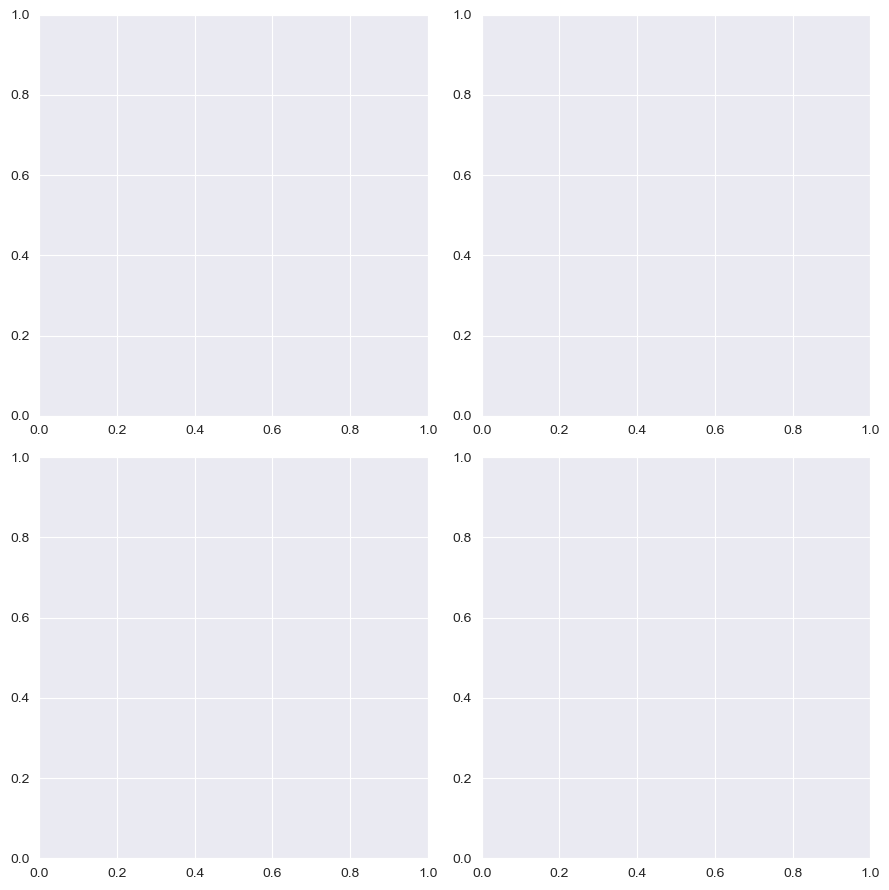

In [14]:
fig, ax0 = plt.subplots(nrows=2,ncols=2, figsize = (9,9))
plt.tight_layout()
ax0 = ax0.flatten()
ax0[0].plot(test_times,node1)
ax0[1].plot(test_times,node2)
ax0[2].plot(test_times,node3)
ax0[3].plot(test_times,node4)
#ax0[4].plot(test_times,node5)
#ax0[5].plot(test_times,node6)
#ax0[6].plot(test_times,node7)
#ax0[7].plot(test_times,node8)
#ax0[8].plot(test_times,node9)
fig.show()

In [ ]:
fig,ax0 = plt.subplots()
ax0.plot(test_times,final)

fig.show()